In [1]:
from planning_through_contact.geometry.planar.planar_pushing_trajectory import PlanarPushingContactMode, PlanarPushingTrajectory
from planning_through_contact.simulation.controllers.hybrid_mpc import HybridMpcConfig
from planning_through_contact.simulation.dynamics.slider_pusher.slider_pusher_system import SliderPusherSystem
import numpy as np
import matplotlib.pyplot as plt

traj = PlanarPushingTrajectory.load("../../trajectories/box_pushing_demos/hw_demo_C_1_rounded.pkl")
for idx, seg in enumerate(traj.traj_segments):
        if seg.mode != PlanarPushingContactMode.NO_CONTACT:
            first_contact_seg = seg
            first_contact_seg_idx = idx
            print(f"First contact segment: {first_contact_seg.mode}, idx {first_contact_seg_idx}")
            break
sys = SliderPusherSystem(
        contact_location=first_contact_seg.mode.to_contact_location(),
        config=traj.config.dynamics_config,
    )
mpc_config = HybridMpcConfig(
    step_size=0.03,
    horizon=35,
    num_sliding_steps=1,
    rate_Hz=50,
    Q=np.diag([3, 3, 0.01, 0]) * 100,
    Q_N=np.diag([3, 3, 1, 0]) * 2000,
    R=np.diag([1, 1, 0]) * 0.5,
)


First contact segment: PlanarPushingContactMode.FACE_1, idx 4


In [2]:
# Arrays to store the graph values
start_time = first_contact_seg.start_time
end_time = first_contact_seg.end_time - 1e-6
num_steps = 100
times, step = np.linspace(start_time, end_time, num_steps, endpoint=True, retstep=True)
contact_pos_list= []
contact_pos_pred_list = []

for t in times:

    state = traj.get_value(t, 'state')
    control = traj.get_value(t, 'control')
    v_WB = traj.get_value(t, 'v_WB')
    # v_WB = sys.get_slider_velocity(state_1, control_1)
    desired_vel_1 = sys.get_v_Wc(state, control, v_WB).flatten()
    contact_pos = traj.get_value(t, 'p_Wc').flatten()
    if t == start_time:
        contact_pos_pred = contact_pos
    else:
        contact_pos_pred = contact_pos_pred_list[-1] + desired_vel_1 * step

    # Storing the values
    contact_pos_list.append(contact_pos)
    contact_pos_pred_list.append(contact_pos_pred)

# Convert lists to numpy arrays for easy plotting
contact_pos_pred_list = np.array(contact_pos_pred_list)
contact_pos_list = np.array(contact_pos_list)

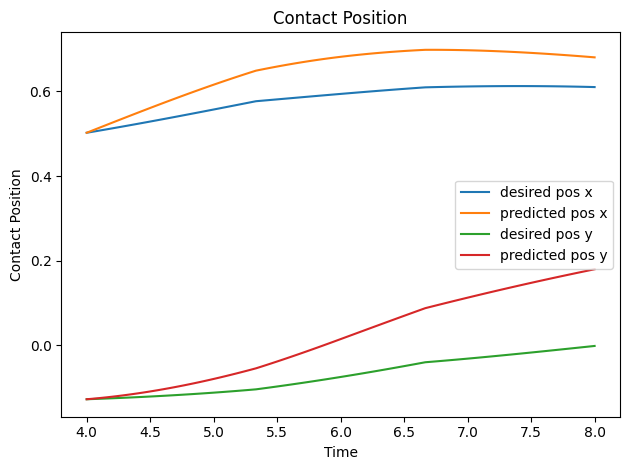

In [3]:
pos_labels = ['x', 'y']
for i in range(2):
    plt.plot(times, contact_pos_list[:, i], label=f"desired pos {pos_labels[i]}")
    plt.plot(times, contact_pos_pred_list[:, i], label=f"predicted pos {pos_labels[i]}")

plt.title(f"Contact Position")
plt.xlabel('Time')
plt.ylabel(f'Contact Position')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Compare v_WB with p_WB
start_time = first_contact_seg.start_time
end_time = first_contact_seg.end_time - 1e-6
num_steps = 100
times, step = np.linspace(start_time, end_time, num_steps, endpoint=True, retstep=True)
state_list = []
pusher_pos_list= []
pusher_pos_pred_list = []
pusher_pos_pred_finite_diff_list = []
slider_pos_list = []
slider_pos_pred_traj_list = []
slider_pos_pred_sys_list = []
v_WB_list = []
v_WB_2_list = []
v_WB_B_list = []
f_c_W_list = []
f_B_list = []
R_WB_from_traj_list = []
R_WB_from_state_list = []

for t in times:

    state = traj.get_value(t, 'state')
    control = traj.get_value(t, 'control')
    v_WB = traj.get_value(t, 'v_WB')
    f_c_W = traj.get_value(t, 'f_c_W').flatten()
    f_B = traj.get_value(t, 'f_B').flatten()
    v_WP = sys.get_pusher_velocity(state, control, v_WB).flatten()
    v_WB_2 = sys.get_slider_velocity(state, control).flatten()
    v_WB_B = sys._get_twist(state[3], control[0], control[1])
    pusher_pos = traj.get_value(t, 'p_WP').flatten()
    slider_pos = traj.get_value(t, 'p_WB').flatten()
    R_WB_from_state = sys._get_R(state[2])[:,0]
    R_WB_from_traj = traj.get_value(t, 'R_WB')[:,0]
    
    if t == start_time:
        pusher_pos_pred = pusher_pos
        slider_pos_pred_sys = slider_pos
        slider_pos_pred_traj = slider_pos
        pusher_pos_pred_finite_diff = sys.get_p_WP_from_state(state).flatten()
    else:
        # Using pusher velocity from system
        pusher_pos_pred = pusher_pos_pred_list[-1] + v_WP * step
        
        # Using pusher velocity from finite difference
        # These steps are equivalent to the following:
        # pusher_pos_pred_finite_diff = sys.get_p_WP_from_state(state).flatten()
        # But I am spelling it out to make the link to finite difference explicit
        x_dot = (state - state_list[-1])/step
        x_at_current_state = state_list[-1] + x_dot * step
        pusher_pos_pred_finite_diff = sys.get_p_WP_from_state(x_at_current_state).flatten()
        
        # Using the slider velocity from the trajectory which is derivative of the position
        slider_pos_pred_traj = slider_pos_pred_traj_list[-1] + v_WB.flatten() * step
        # Using slider velocity from system
        slider_pos_pred_sys = slider_pos_pred_sys_list[-1] + v_WB_2 * step

    # Storing the values
    state_list.append(state)
    pusher_pos_pred_finite_diff_list.append(pusher_pos_pred_finite_diff)
    pusher_pos_list.append(pusher_pos)
    pusher_pos_pred_list.append(pusher_pos_pred)
    slider_pos_list.append(slider_pos)
    slider_pos_pred_traj_list.append(slider_pos_pred_traj)
    slider_pos_pred_sys_list.append(slider_pos_pred_sys)
    v_WB_list.append(v_WB.flatten())
    v_WB_2_list.append(v_WB_2)
    f_c_W_list.append(f_c_W)
    f_B_list.append(f_B)
    v_WB_B_list.append(v_WB_B)
    R_WB_from_state_list.append(R_WB_from_state)
    R_WB_from_traj_list.append(R_WB_from_traj)

# Convert lists to numpy arrays for easy plotting
pusher_pos_pred_list = np.array(pusher_pos_pred_list)
pusher_pos_list = np.array(pusher_pos_list)
pusher_pos_pred_finite_diff_list = np.array(pusher_pos_pred_finite_diff_list)
slider_pos_pred_traj_list = np.array(slider_pos_pred_traj_list)
slider_pos_pred_sys_list = np.array(slider_pos_pred_sys_list)
slider_pos_list = np.array(slider_pos_list)
v_WB_list = np.array(v_WB_list)
v_WB_2_list = np.array(v_WB_2_list)
f_c_W_list = np.array(f_c_W_list)
f_B_list = np.array(f_B_list)
v_WB_B_list = np.array(v_WB_B_list)
R_WB_from_traj_list = np.array(R_WB_from_traj_list)
R_WB_from_state_list = np.array(R_WB_from_state_list)


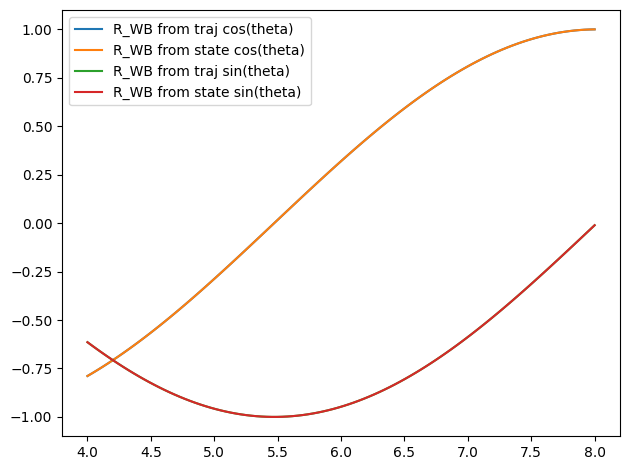

In [5]:
R_labels = ['cos(theta)', 'sin(theta)']
for i in range(2):
    plt.plot(times, R_WB_from_traj_list[:, i], label=f"R_WB from traj {R_labels[i]}")
    plt.plot(times, R_WB_from_state_list[:, i], label=f"R_WB from state {R_labels[i]}")
plt.legend()

plt.tight_layout()
plt.show()

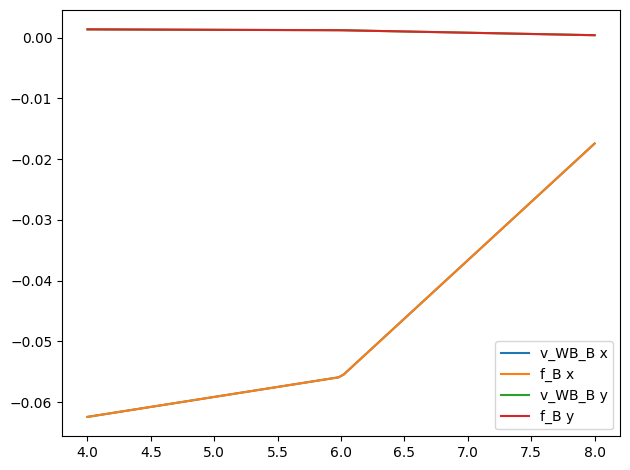

In [6]:
pos_labels = ['x', 'y']

for i in range(2):
    plt.plot(times, v_WB_B_list[:, i], label=f"v_WB_B {pos_labels[i]}")
    plt.plot(times, f_B_list[:, i], label=f"f_B {pos_labels[i]}")

plt.legend()

plt.tight_layout()
plt.show()

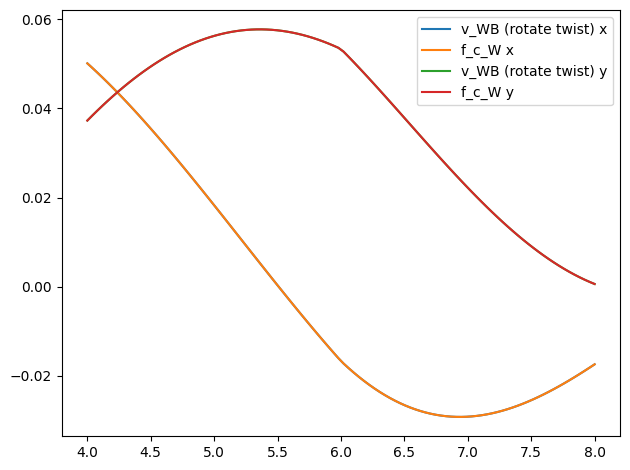

In [7]:
pos_labels = ['x', 'y']

for i in range(2):
    plt.plot(times, v_WB_2_list[:, i], label=f"v_WB (rotate twist) {pos_labels[i]}")
    plt.plot(times, f_c_W_list[:, i], label=f"f_c_W {pos_labels[i]}")

plt.legend()

plt.tight_layout()
plt.show()

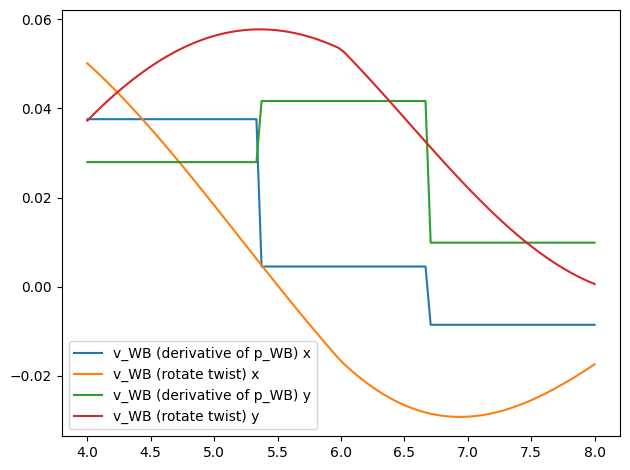

In [8]:
pos_labels = ['x', 'y']
R_labels = ['cos(theta)', 'sin(theta)']
control_labels = ['c_n', 'c_f', 'lam_dot']
control_labels = ['f_c_x', 'f_c_y']
for i in range(2):
    plt.plot(times, v_WB_list[:, i], label=f"v_WB (derivative of p_WB) {pos_labels[i]}")
    plt.plot(times, v_WB_2_list[:, i], label=f"v_WB (rotate twist) {pos_labels[i]}")
plt.legend()

plt.tight_layout()
plt.show()

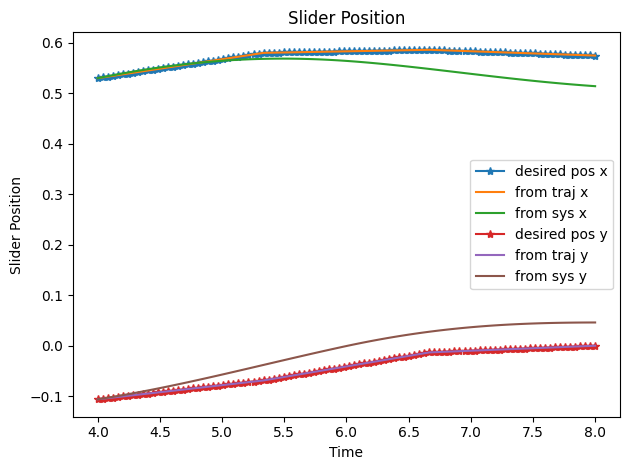

In [17]:
pos_labels = ['x', 'y']
for i in range(2):
    plt.plot(times, slider_pos_list[:, i], label=f"desired pos {pos_labels[i]}", marker='*')
    plt.plot(times, slider_pos_pred_traj_list[:, i], label=f"from traj {pos_labels[i]}")
    plt.plot(times, slider_pos_pred_sys_list[:, i], label=f"from sys {pos_labels[i]}")

plt.title(f"Slider Position")
plt.xlabel('Time')
plt.ylabel(f'Slider Position')
plt.legend()

plt.tight_layout()
plt.show()

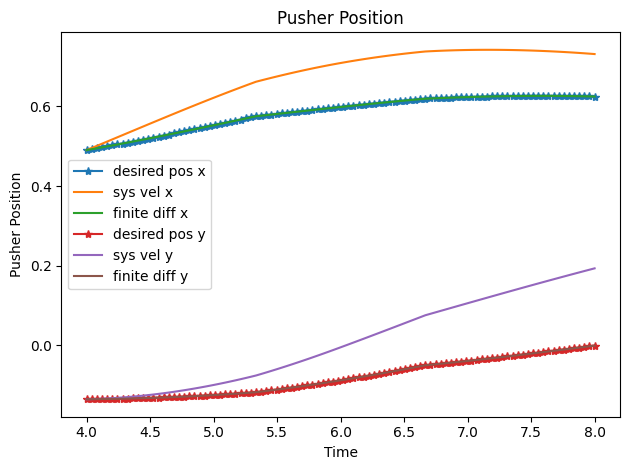

In [27]:
pos_labels = ['x', 'y']
for i in range(2):
    plt.plot(times, pusher_pos_list[:, i], label=f"desired pos {pos_labels[i]}", marker='*')
    plt.plot(times, pusher_pos_pred_list[:, i], label=f"sys vel {pos_labels[i]}")
    plt.plot(times, pusher_pos_pred_finite_diff_list[:, i], label=f"finite diff {pos_labels[i]}")

plt.title(f"Pusher Position")
plt.xlabel('Time')
plt.ylabel(f'Pusher Position')
plt.legend()

plt.tight_layout()
plt.show()